In [52]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import itertools
from pyspark.mllib.recommendation import ALS
from pyspark.sql.functions import col
import math
import random
import itertools

from cross_validation import KFoldIndexes,CrossValidation
from cross_validation_blending import CrossValidationBlending
from models.als import predictions_ALS
from models.MF_SGD import matrix_factorization_SGD
from models.means import *
from models.medians import *
from helpers import *
from models.helpers import *
from rescaler import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.options.display.max_columns = 100

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
df = load_csv()
df.head()

,User,Movie,Rating
0,44,1,4
1,61,1,3
2,67,1,4
3,72,1,3
4,86,1,5


In [55]:
rescaler = Rescaler(df)
new_df = rescaler.normalize()

In [56]:
new_df.head(5)

,User,Movie,Rating
0,44,1,0.092061
1,61,1,-1.476069
2,67,1,0.481774
3,72,1,-0.553645
4,86,1,1.066032


In [66]:
train, test = split(df, 0.1)
train_norm, test_norm = split(new_df, 0.1)

In [67]:
MF_SGD = matrix_factorization_SGD(train, test,n_iter=3)
print("MF_SGD: ", evaluate(MF_SGD, test))
user_m = user_mean(train, test)
print("user mean: ", evaluate(user_m, test))
movie_m = movie_mean(train, test)
print("movie_mean: ", evaluate(movie_m, test))

[MF-SGD] gamma=0.004, features=20, iterations=3
[MF-SGD] RMSE on train set: 0.9928502088907052
[MF-SGD] Done
MF_SGD:  1.00060033131
[USER_MEAN] applying
[USER_MEAN] done
user mean:  1.15015855475
[MOVIE_MEAN] applying
[MOVIE_MEAN] done
movie_mean:  1.1948657305


In [71]:
blend = blender([MF_SGD, user_m, movie_m], [0.8, 0., 0.2])
print("blend: ", evaluate(blend, test))
blend.head()

blend:  1.00044215672


,User,Movie,Rating
0,90,1,3.299252
1,165,1,3.353518
2,333,1,3.241318
3,470,1,3.729938
4,673,1,2.987755


## And now: rescaled

In [73]:
MF_SGD_norm = rescaler.recover(matrix_factorization_SGD(train_norm, test,n_iter=3))
print("MF_SGD: ", evaluate(MF_SGD_norm, test))
user_m_norm = rescaler.recover(user_mean(train_norm, test))
print("user mean: ", evaluate(user_m_norm, test))
movie_m_norm = rescaler.recover(movie_mean(train_norm, test))
print("movie_mean: ", evaluate(movie_m_norm, test))

[MF-SGD] gamma=0.004, features=20, iterations=3
[MF-SGD] RMSE on train set: 0.950070787579481
[MF-SGD] Done
MF_SGD:  1.08245917776
[USER_MEAN] applying
[USER_MEAN] done
user mean:  1.15023663466
[MOVIE_MEAN] applying
[MOVIE_MEAN] done
movie_mean:  1.23890138452


In [74]:
blend_norm = blender([MF_SGD_norm, user_m_norm, movie_m_norm], [0.8, 0., 0.2])
print("blend: ", evaluate(blend_norm, test))
blend.head()

blend:  1.04925794632


,User,Movie,Rating
0,90,1,3.299252
1,165,1,3.353518
2,333,1,3.241318
3,470,1,3.729938
4,673,1,2.987755


## Normalize only mean

In [78]:
from rescaler import *
rescaler2 = Rescaler(df)
mean_df = rescaler2.normalize_only_mean()
train_norm_mean, test_norm_mean = split(mean_df, 0.1)

In [85]:
MF_SGD_norm_mean.head(5)

,User,Movie,Rating
0,90,1,NaN
1,165,1,NaN
2,333,1,NaN
3,470,1,NaN
4,673,1,NaN


In [82]:
user_m_norm_mean = rescaler2.recover_only_mean(user_mean(train_norm_mean, test))
print("user mean: ", evaluate(user_m_norm_mean, test))
movie_m_norm_mean = rescaler2.recover_only_mean(movie_mean(train_norm_mean, test))
print("movie_mean: ", evaluate(movie_m_norm_mean, test))
MF_SGD_norm_mean = rescaler2.recover_only_mean(matrix_factorization_SGD(train_norm_mean, test,n_iter=3))
print("MF_SGD: ", evaluate(MF_SGD_norm_mean, test))


[USER_MEAN] applying
[USER_MEAN] done
user mean:  1.15011047122
[MOVIE_MEAN] applying
[MOVIE_MEAN] done
movie_mean:  1.22479675221
[MF-SGD] gamma=0.004, features=20, iterations=3
[MF-SGD] RMSE on train set: nan
[MF-SGD] Done
MF_SGD:  nan


## deviation

In [108]:
from rescaler import *
rescaler = Rescaler(df)
dev_df = rescaler.normalize_deviation()
train_dev, test_dev = split(dev_df, 0.1)

In [109]:
user_m_dev = rescaler.recover_deviation(user_mean(train_dev, test))
print("user mean: ", evaluate(user_m_dev, test))
movie_m_dev = rescaler.recover_deviation(movie_mean(train_dev, test))
print("movie_mean: ", evaluate(movie_m_dev, test))
MF_SGD_dev = rescaler.recover_deviation(matrix_factorization_SGD(train_dev, test,n_iter=3))
print("MF_SGD: ", evaluate(MF_SGD_dev, test))

[USER_MEAN] applying
[USER_MEAN] done
user mean:  1.15079401632
[MOVIE_MEAN] applying
[MOVIE_MEAN] done
movie_mean:  1.22441404614
[MF-SGD] gamma=0.004, features=20, iterations=3
[MF-SGD] RMSE on train set: 0.9912640862361735
[MF-SGD] Done
MF_SGD:  0.993269765876


In [111]:
print("MF_SGD standard: ", evaluate(MF_SGD, test))
print("MF_SGD deviation normalization: ", evaluate(MF_SGD_dev, test))
print("improve: ", evaluate(MF_SGD, test) - evaluate(MF_SGD_dev, test))

MF_SGD standard:  1.00060033131
MF_SGD deviation normalization:  0.993269765876
improve:  0.00733056543563


In [88]:
d = dict(df.groupby('User').mean().Rating)

In [99]:
np.mean(list(d.values()))

3.8321255854690826

In [146]:
sgd_ws = np.arange(0.1, 1, 0.02)
scores = []

for sgd_w in sgd_ws:
    mean_w = (1 - sgd_w) / 4
    blender = blend([MF_SGD, movie_m, user_m], [sgd_w, 4 * mean_w, 0* mean_w])
    score = evaluate(blender, test)
    scores.append(score)

TypeError: 'DataFrame' object is not callable

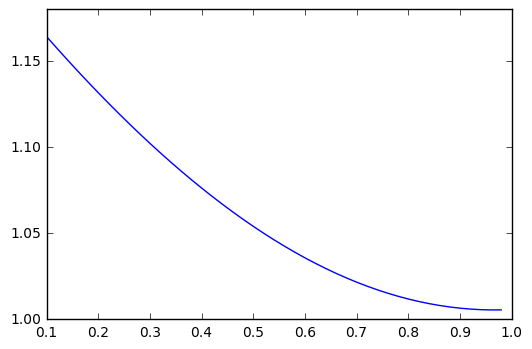

In [133]:
plt.plot(sgd_ws, scores)

In [136]:
blender = blend2([MF_SGD, movie_m, user_m], [0.8, 0.2 , 0])

In [138]:
blender.head()

,User,Movie,Rating
0,44,1,3.479377
1,595,1,3.253373
2,1830,1,3.840729
3,2347,1,2.994840
4,2681,1,3.305269


## Do the prediction

In [4]:
df_kaggle = load_csv_kaggle()

In [6]:
df_kaggle.shape

(1176952, 3)

In [142]:
pred_MF = matrix_factorization_SGD(df, df_kaggle)

[MF-SGD] gamma=0.004, features=20, iterations=20
[MF-SGD] RMSE on train set: 0.9908975630629757
[MF-SGD] Done


In [143]:
pred_user = user_mean(df, df_kaggle)
pred_movie = movie_mean(df, df_kaggle)

[USER_MEAN] applying
[USER_MEAN] done
[MOVIE_MEAN] applying
[MOVIE_MEAN] done


In [148]:
blend = blender([pred_MF, pred_movie, pred_user], [0.8, 0.2, 0])
blend.head()

,User,Movie,Rating
0,37,1,3.313702
1,73,1,3.106057
2,156,1,3.617039
3,160,1,3.317579
4,248,1,3.330541


In [149]:
submission = submission_table(blend, 'User', 'Movie', 'Rating')

In [152]:
submission.head()

,Id,Prediction
0,r37_c1,3.313702
1,r73_c1,3.106057
2,r156_c1,3.617039
3,r160_c1,3.317579
4,r248_c1,3.330541


In [153]:
submission.to_csv('../preds/blend_0.8MF_0.2MovieM.csv', index=False)